# Lab 5: Land Surface Temperature using CORINE-based Emissivity

## 🎯 Objectives
In this exercise, you will:
- Select a cloud-free Landsat 8 images from 2013 and 2023 (or different if you're sure that you'll spot a difference in land cover)
- Calculate Brightness Temperature (TB) from Band 10.
- Load CORINE Land Cover data and assign emissivity values to each land cover class.
- Use the Planck-based formula to calculate Land Surface Temperature (LST).
- Visualize and interpret the results.

## Step 1: Define Area of Interest (AOI)
- Use coordinates around Reduta street in Kraków.
- Create a polygon or rectangle using `ee.Geometry.Polygon`.

In [17]:
import ee
import geemap
#ee.Authenticate()
ee.Initialize(project='ee-kkosciukk')

In [8]:
aoi = ee.Geometry.Rectangle([19.947306, 50.097058, 19.969359, 50.103414])


## Step 2: Load Landsat 8 imagery for the dates you've picked
- Filter for low cloud cover (< 20%)
- Select Band 10 and convert to TB using: `TB = ST_B10 * 0.00341802 + 149.0`

In [5]:
# Load image and calculate TB
image_2013 = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterBounds(aoi)
    .filterDate('2013-08-01', '2013-08-30')
    .filterMetadata('CLOUD_COVER', 'less_than', 20)
    .first()
)

image_2024 = (
    ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')
    .filterBounds(aoi)
    .filterDate('2024-08-01', '2024-08-30')
    .filterMetadata('CLOUD_COVER', 'less_than', 20)
    .first()
)

tb_image_2013 = image_2013.select('ST_B10').multiply(0.00341802).add(149.0).rename('TB_2013');

tb_image_2024 = image_2024.select('ST_B10').multiply(0.00341802).add(149.0).rename('TB_2024');

In [6]:
print(image_2013.getInfo())
print(image_2024.getInfo())


{'type': 'Image', 'bands': [{'id': 'SR_B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7961, 8051], 'crs': 'EPSG:32634', 'crs_transform': [30, 0, 303885, 0, -30, 5690715]}, {'id': 'SR_B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7961, 8051], 'crs': 'EPSG:32634', 'crs_transform': [30, 0, 303885, 0, -30, 5690715]}, {'id': 'SR_B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7961, 8051], 'crs': 'EPSG:32634', 'crs_transform': [30, 0, 303885, 0, -30, 5690715]}, {'id': 'SR_B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7961, 8051], 'crs': 'EPSG:32634', 'crs_transform': [30, 0, 303885, 0, -30, 5690715]}, {'id': 'SR_B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7961, 8051], 'crs': 'EPSG:32634', 'crs_transform': [30, 0, 303885, 0, -30

## Step 3: Load CORINE Land Cover data
- Use dataset `COPERNICUS/CORINE/V20/100m/2018`
- Clip it to your AOI

In [7]:
# Load CORINE
corine_2018 = (
    ee.Image('COPERNICUS/CORINE/V20/100m/2018')
)

corine_2018 = corine_2018.clip(aoi)

## Step 4: Assign emissivity to CORINE classes
- Use a dictionary for classes
- Use `remap()` and optionally a default value

In [8]:
# Create emissivity image

emissivity_dict = {
    111: 0.92,  # Continuous urban fabric
    112: 0.92,  # Discontinuous urban fabric
    121: 0.91,  # Industrial or commercial units
    211: 0.96,  # Non-irrigated arable land
    311: 0.98,  # Forests
    412: 0.97,  # Peat bogs
    324: 0.96,  # Transitional woodland-shrub
    231: 0.97   # Pastures
}
key_emissivity = list(emissivity_dict.keys())
values_emissivity = list(emissivity_dict.values())

emissivity_image = corine_2018.remap(key_emissivity, values_emissivity)

## Step 5: Calculate LST using the formula:
$$
LST = \frac{T_B}{1 + \left( \frac{\lambda \cdot T_B}{c_2} \right) \cdot \ln(\varepsilon)}
$$
- λ = 10.8 µm
- c₂ = 14388 µm·K

In [9]:
lambda_ = 10.8
c2 = 14388

lst_image = tb_image_2013.expression(
    'TB / (1 + ((lambda * TB) / c2) * log(1.0 / emissivity))', {
        'TB': tb_image_2013,
        'emissivity': emissivity_image,
        'lambda': lambda_,
        'c2': c2
    }).rename('LST')

## Step 6: Visualize the LST result
- Use palette: `['blue', 'yellow', 'red']`
- Suggested range: `min=290`, `max=325`

In [10]:
# Visualize LST
Map = geemap.Map()
Map.centerObject(aoi, zoom=15)

vis_params = {
    'palette': ['blue', 'yellow', 'red'],
    'min': 290,
    'max': 325,
}

Map.addLayer(lst_image, vis_params, 'LST')
Map

Map(center=[50.100236451862415, 19.95833250000626], controls=(WidgetControl(options=['position', 'transparent_…

## Step 7: (Optional) Analyze statistics by land cover class

In [11]:
# Optionally compute zonal statistics

lst_with_class = lst_image.addBands(corine_2018.rename('class'))


stats = lst_with_class.reduceRegion(
    reducer=ee.Reducer.mean().group(
        groupField=1,
        groupName='class'
    ),
    geometry=aoi,
    scale=100,  # Match CORINE resolution
    maxPixels=1e13
)


grouped_stats = stats.get('groups')
grouped_stats = ee.List(grouped_stats)

def safe_format_dict(d):
    d = ee.Dictionary(d)
    land_class = ee.Number(d.get('class'))
    mean_val = ee.Algorithms.If(d.contains('mean'), ee.Number(d.get('mean')).format('%.2f'), 'N/A')
    return ee.String('Class: ').cat(land_class.format()).cat(', Mean LST: ').cat(mean_val)


formatted = grouped_stats.map(safe_format_dict)
print(formatted.getInfo())


['Class: 112, Mean LST: 306.86', 'Class: 121, Mean LST: 308.99', 'Class: 211, Mean LST: 312.93', 'Class: 243, Mean LST: N/A']


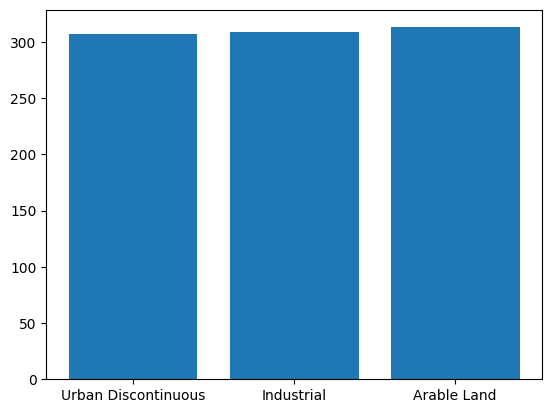

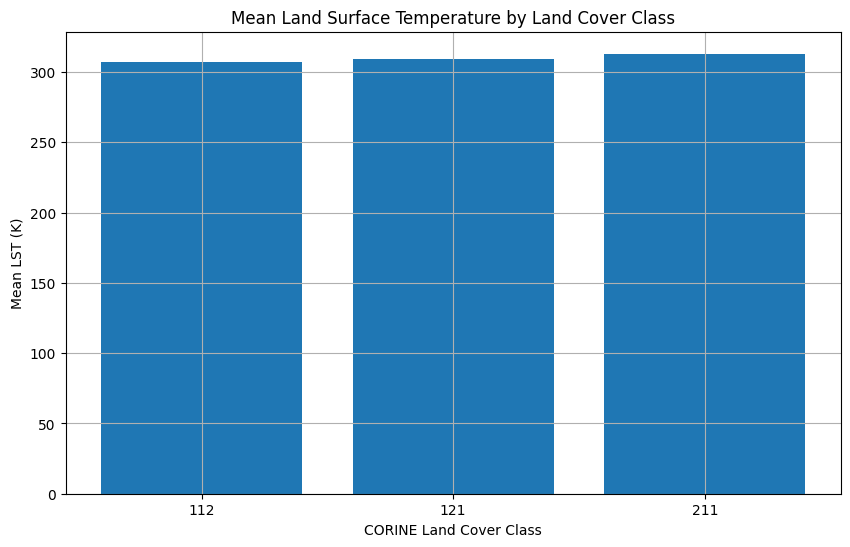

In [12]:
import pandas as pd
import matplotlib.pyplot as plt


grouped_list = grouped_stats.getInfo()


data = []
for item in grouped_list:
    class_id = item.get('class')
    mean_lst = item.get('mean')
    if mean_lst is not None:
        data.append({'Class': class_id, 'Mean_LST': mean_lst})

df = pd.DataFrame(data).sort_values(by='Mean_LST')

corine_labels = {
    111: 'Urban Continuous',
    112: 'Urban Discontinuous',
    121: 'Industrial',
    211: 'Arable Land',
    231: 'Pastures',
    311: 'Forests',
    324: 'Shrubland',
    412: 'Peat Bogs'
}

df['Label'] = df['Class'].map(corine_labels)
plt.bar(df['Label'], df['Mean_LST'])

plt.figure(figsize=(10, 6))
plt.bar(df['Class'].astype(str), df['Mean_LST'])
plt.xlabel('CORINE Land Cover Class')
plt.ylabel('Mean LST (K)')
plt.title('Mean Land Surface Temperature by Land Cover Class')
plt.grid(True)
plt.show()

## Step 8: (Optional - Easter Egg :)) Generate your own Land Cover Classification using TerraTorch and foundation models*

Based on the example/tutorial: https://aiforgood.itu.int/event/workshop-earth-observation-foundation-models-with-prithvi-eo-2-0-and-terratorch/

*to earn 5.0 grade that will make a great impact on your final grade